In [1]:
##Here we expand numbers in p-adic

In [315]:
import numpy as np
from fractions import Fraction

# ------------------------------------------------------------
# Extended Euclidean Algorithm
# ------------------------------------------------------------
def Extended_Euclidean_Recursive(a, b):
    if b == 0:
        return a, 1, 0
    g, x1, y1 = Extended_Euclidean_Recursive(b, a % b)
    return g, y1, x1 - (a // b) * y1

# ------------------------------------------------------------
# p-adic valuation
# ------------------------------------------------------------
def v_p(n, p):
    n = abs(n)
    k = 0
    while n % p == 0 and n != 0:
        n //= p
        k += 1
    return k

# ------------------------------------------------------------
# Positive p-adic expansion (handles denominators divisible by p)
# digits are least-significant first
# ------------------------------------------------------------
def p_expansion_positive(r, s, p, n, *, report=False):
    """
    Compute the p-adic expansion digits of x = r/s (r,s>0) up to n digits.
    Handles denominators divisible by p. If report=True, prints any valuation shift.
    """
    # factor out powers of p from r and s
    v_r = v_p(r, p)
    v_s = v_p(s, p)
    shift = v_r - v_s            # overall power of p (v_p(x))
    r_ = r // (p ** v_r)
    s_ = s // (p ** v_s)

    # s_ now coprime to p
    x = Fraction(r_, s_)
    digits = []
    s_partial = Fraction(0, 1)
    f_prev = x

    for i in range(n):
        r_i = f_prev.numerator
        s_i = f_prev.denominator

        g, u, _ = Extended_Euclidean_Recursive(s_i % p, p)
        if g != 1:
            raise ValueError("Denominator not invertible mod p.")
        u %= p

        # a_i = ((r_i mod p)*(s_i^{-1} mod p)) mod p
        a_i = ((r_i % p) * u) % p
        digits.append(a_i)

        # update next fractional term
        s_partial = s_partial + Fraction(a_i * (p ** i), 1)
        f_prev = (x - s_partial) / (p ** (i + 1))

    # apply valuation shift and REPORT it
    if shift > 0:
        if report:
            print(f"[shift] v_p(x) = {shift} ⇒ prepending {shift} zero digit(s).")
        digits = ([0] * shift + digits)[:n]
    elif shift < 0:
        if report:
            print(f"[shift] v_p(x) = {shift} ⇒ series starts at power p^{shift} (negative index).")
            
    return digits, shift

# ------------------------------------------------------------
# General p-adic expansion with correct negative handling
# ------------------------------------------------------------
def p_expansion(r, s, p, n):
    if r == 0:
        return [0]*n,0

    neg = (r < 0) ^ (s < 0)
    r_abs, s_abs = abs(r), abs(s)

    pos,shift = p_expansion_positive(r_abs, s_abs, p, n)
    if not neg:
        return pos,shift

    # find first nonzero digit index k
    k = None
    for i, d in enumerate(pos):
        if d % p != 0:
            k = i
            break

    neg_digits = [0]*n
    if k is None:
        # |x| ≡ 0 mod p^n ⇒ -x also ≡ 0 mod p^n
        return neg_digits,shift 

    for i in range(n):
        if i < k:
            neg_digits[i] = 0                         # *** FIX: was p-1
        elif i == k:
            neg_digits[i] = (p - pos[i]) % p
        else:
            neg_digits[i] = (p - 1 - pos[i]) % p

    return neg_digits,shift 

In [8]:
import pandas as pd
from fractions import Fraction

# (keep your original definitions: Extended_Euclidean_Recursive, v_p, p_expansion_positive, p_expansion)

# ------------------------------------------------------------
# Generate DataFrame of examples
# ------------------------------------------------------------
def p_adic_example_table(p, n):
    examples = [
        (1, 1), (2, 1), (3, 1), (4, 1),
        (1, 2), (1, 3), (2, 3), (3, 2),
        (7, 5), (8, 25), (1, 25), (9, 125),
        (-1, 1), (-2, 3), (-3, 2), (-7, 5),
        (5, 1), (25, 1), (125, 1)
    ]

    data = []
    for r, s in examples:
        try:
            digits = p_expansion(r, s, p, n)
            x = Fraction(r, s)
            data.append({
                "r": r,
                "s": s,
                "x = r/s": str(x),
                f"{p}-adic digits (least significant first)": digits
            })
        except Exception as e:
            data.append({
                "r": r,
                "s": s,
                "x = r/s": str(Fraction(r, s)),
                f"{p}-adic digits (least significant first)": f"Error: {e}"
            })

    df = pd.DataFrame(data)
    df.index = [f"ex{i+1}" for i in range(len(df))]
    return df

# ------------------------------------------------------------
# Display table
# ------------------------------------------------------------
df = p_adic_example_table(p=11, n=8)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.colheader_justify", "center")
print("\n" + "="*85)
print(f"{5}-adic expansions up to 8 digits".center(85))
print("="*85)
print(df.to_markdown(index=True, tablefmt="grid"))



                           5-adic expansions up to 8 digits                          
+------+-----+-----+-----------+--------------------------------------------+
|      |   r |   s | x = r/s   | 11-adic digits (least significant first)   |
+======+=====+=====+===========+============================================+
| ex1  |   1 |   1 | 1         | ([1, 0, 0, 0, 0, 0, 0, 0], 0)              |
+------+-----+-----+-----------+--------------------------------------------+
| ex2  |   2 |   1 | 2         | ([2, 0, 0, 0, 0, 0, 0, 0], 0)              |
+------+-----+-----+-----------+--------------------------------------------+
| ex3  |   3 |   1 | 3         | ([3, 0, 0, 0, 0, 0, 0, 0], 0)              |
+------+-----+-----+-----------+--------------------------------------------+
| ex4  |   4 |   1 | 4         | ([4, 0, 0, 0, 0, 0, 0, 0], 0)              |
+------+-----+-----+-----------+--------------------------------------------+
| ex5  |   1 |   2 | 1/2       | ([6, 5, 5, 5, 5, 5, 5,

In [10]:
## Here we find the corresponding euclidean number of a p adic expansion

In [12]:
def p_pow_frac(p: int, e: int) -> Fraction:
    """Exact p^e as Fraction (supports negative e)."""
    return Fraction(p**e, 1) if e >= 0 else Fraction(1, p**(-e))

def normalize_digits(digs, p, order: str):
    """
    Ensure digits are least-significant-first and validated.
    order: 'lsf' (least-significant-first) or 'msf' (most-significant-first).
    """
    if order not in ("lsf", "msf"):
        raise ValueError("order must be 'lsf' or 'msf'")
    if any((d < 0 or d >= p) for d in digs):
        raise ValueError("All digits must be in [0, p-1].")
    return list(digs) if order == "lsf" else list(reversed(digs))

def p_adic_to_euclidean(prefix, cycle, p, start_power=0, order="lsf") -> Fraction:
    """
    Convert a p-adic expansion with arbitrary start power r to an exact Euclidean Fraction.

    Parameters
    ----------
    prefix : list[int]
        finite non-repeating digits (a_0, ..., a_{k-1})
    cycle  : list[int]
        repeating block digits (b_0, ..., b_{m-1}); empty => finite expansion only
    p : int
        prime base
    start_power : int
        r, the exponent of the first prefix digit (series starts at p^r)
    order : 'lsf' or 'msf'
        whether `prefix` and `cycle` are given least- or most-significant-first

    Returns
    -------
    Fraction : exact rational value
    """
    # normalize to least-significant-first
    prefix = normalize_digits(prefix, p, order)
    cycle  = normalize_digits(cycle,  p, order)

    k = len(prefix)
    m = len(cycle)

    # A0 = sum_{i=0}^{k-1} a_i p^i  (exact)
    A0 = Fraction(0, 1)
    for i, a in enumerate(prefix):
        if a:
            A0 += Fraction(a, 1) * p_pow_frac(p, i)

    if m == 0:
        # finite expansion: x = p^r * A0
        return p_pow_frac(p, start_power) * A0

    # B0 = sum_{j=0}^{m-1} b_j p^j  (exact)
    B0 = Fraction(0, 1)
    for j, b in enumerate(cycle):
        if b:
            B0 += Fraction(b, 1) * p_pow_frac(p, j)

    # x = p^r * ( A0 + p^k * B0 / (1 - p^m) )
    numer_tail = p_pow_frac(p, k) * B0          # p^k * B0
    geom = Fraction(1, 1 - (p**m))              # 1/(1 - p^m) exact (integer denom)
    inner = A0 + numer_tail * geom
    x = p_pow_frac(p, start_power) * inner
    return x

In [14]:
# ------------------------------------------------------------
# Display results cleanly with exact fractions
# ------------------------------------------------------------
rows = []
for prefix, cycle, p, start_power, desc in examples:
    x = p_adic_to_euclidean(prefix, cycle, p, start_power)
    rows.append({
        "Description": desc,
        "Base p": p,
        "Prefix": prefix,
        "Cycle": cycle,
        "Start power r": start_power,
        "Exact rational (Fraction)": f"{x.numerator}/{x.denominator}",
        "≈ Decimal": f"{float(x):.6f}"
    })

df = pd.DataFrame(rows)

# Format clean table with Markdown borders and aligned columns
pd.set_option("display.max_colwidth", None)
pd.set_option("display.colheader_justify", "center")

print("\n" + "="*90)
print("Reconstruction of Euclidean Rational Numbers from p-adic Expansions".center(90))
print("="*90)
print(df.to_markdown(index=False, tablefmt="grid"))


NameError: name 'examples' is not defined

In [434]:
##Here we give the basic algorithm of preceding plotting function, that is finding the reminder of rational number and negative numbers using 
##their p adic expansion, and finding modular inverse using EEA
# ------------------------------------------------------------
# p-adic remainder modulo p^n
# ------------------------------------------------------------
import random
def p_adic_remainder(r, s, p, n):
    digits, shift = p_expansion(r, s, p, n)
    dim = len(digits)
    if shift < 0:
        return 'Modular not Defined'
    elif shift >= 0:
        coefficients = []
        for i in range(0, dim+1):
            coefficients.append((p**i))
        remainder = sum(a * c for a, c in zip(digits, coefficients))
        return remainder


def mod_inverse(a, mod):
    g, x, y = Extended_Euclidean_Recursive(a, mod)
    if g != 1:
        raise ValueError(f"No modular inverse for {a} mod {mod}")
    return x % mod
p_adic_remainder(351, 100, 3, 3)

0

In [233]:
## Here we create a p-adic straight line

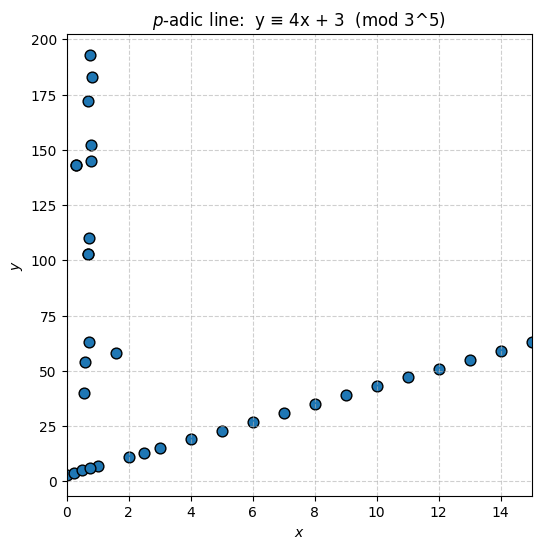

In [470]:
import numpy as np
import matplotlib.pyplot as plt

def p_adic_line(a, b, p, n,include_fraction=True):
    x_min = 0
    x_max=15
    ##x_max =p**n - 1
    mod = p ** n
    y_output=[]

    x_values = []

    # include all integers (guaranteed)
    for i in range(x_min, x_max + 1):
        x_values.append(Fraction(i, 1))


    extra_fractions = [
        Fraction(5, 2),
        Fraction(4, 7),
        Fraction(3, 5),
        Fraction(2, 7),
        Fraction(1, 4),
        Fraction(1, 2),
        Fraction(2, 7),
        Fraction(3, 4),
        Fraction(4, 5),
        Fraction(5, 7),
        Fraction(7, 10),
        Fraction(8, 5),
        Fraction(9, 11),
        Fraction(10, 13),
        Fraction(11, 14),
        Fraction(12, 17),
        Fraction(13, 19),
        Fraction(14, 20)
    ]
    x_values += extra_fractions

    for frac in x_values:
        r, s = frac.numerator, frac.denominator
        intermediate=Fraction(a * r, s) + b
        if intermediate==0:
            y_output.append(0)
            continue
        numerator, denominator=intermediate.numerator, intermediate.denominator
        y_output.append(p_adic_remainder(numerator, denominator, p, n))
    x_plot = [float(frac) for frac in x_values]
    
    plt.figure(figsize=(6, 6))
    plt.scatter(x_plot, y_output, edgecolor='black', s=60)
    plt.title(f"$p$-adic line:  y ≡ {a}x + {b}  (mod {p}^{n})")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    ##plt.axis("equal")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlim(x_min, x_max)
    plt.show()

# Example usage:
p_adic_line(a=4, b=3, p=3, n=5)


Plotting for a=1, b=0, p=2, n=3


/var/folders/g_/gl9qzqvj183d1pncyg_kxj380000gp/T/ipykernel_93415/3005622508.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_plot, y_output, cmap='viridis', edgecolor='black', s=60)


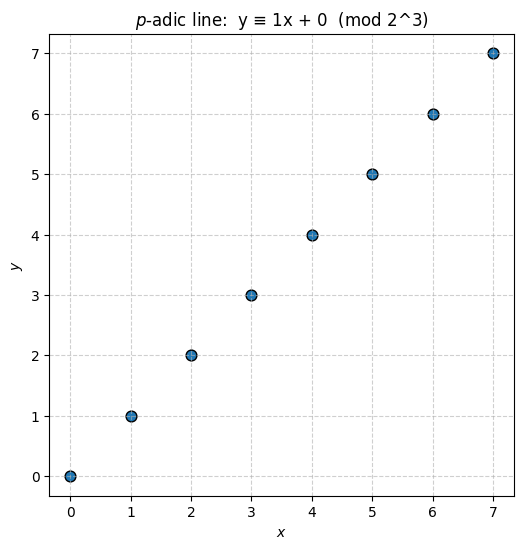

Plotting for a=1, b=1, p=2, n=3


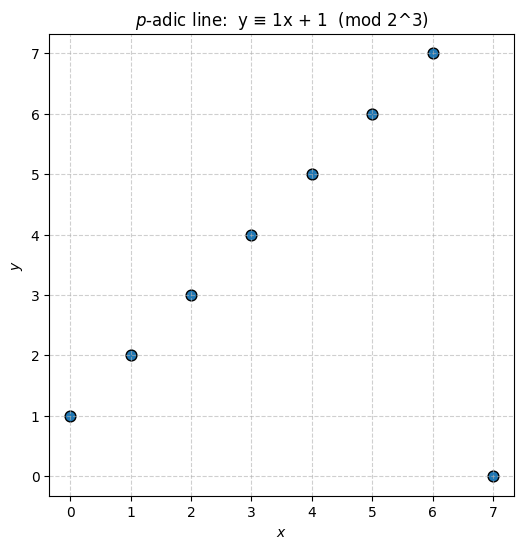

Plotting for a=3, b=0, p=2, n=4


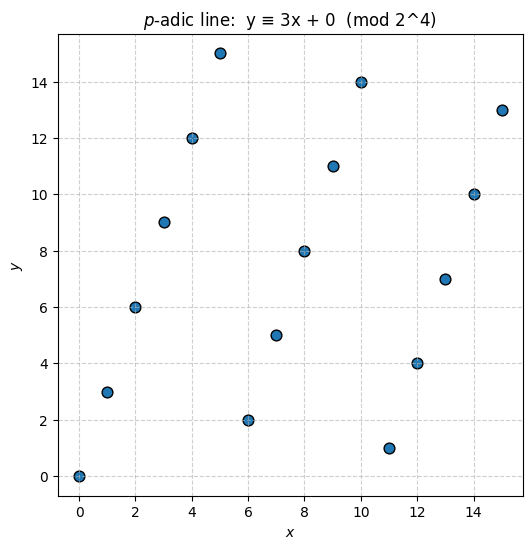

Plotting for a=5, b=7, p=2, n=5


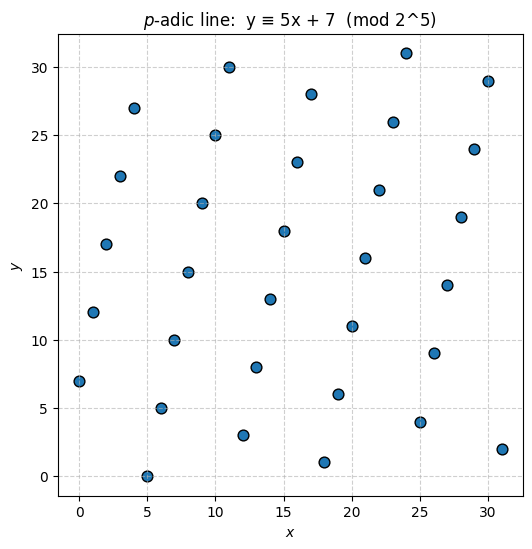

Plotting for a=1, b=0, p=2, n=6


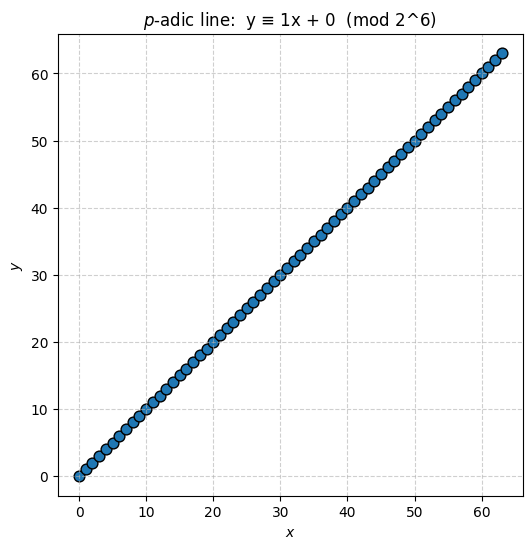

Plotting for a=1, b=0, p=3, n=3


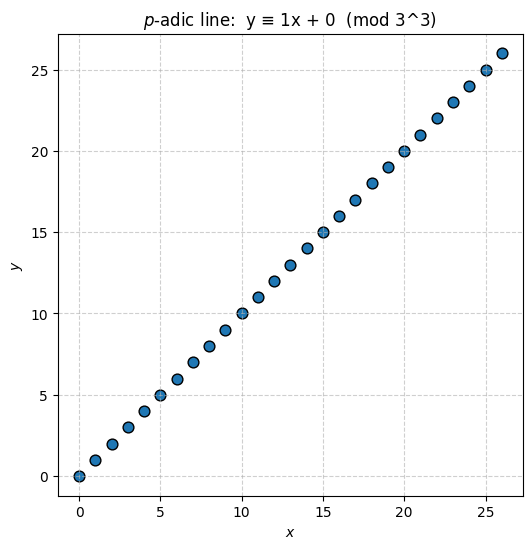

Plotting for a=2, b=0, p=3, n=3


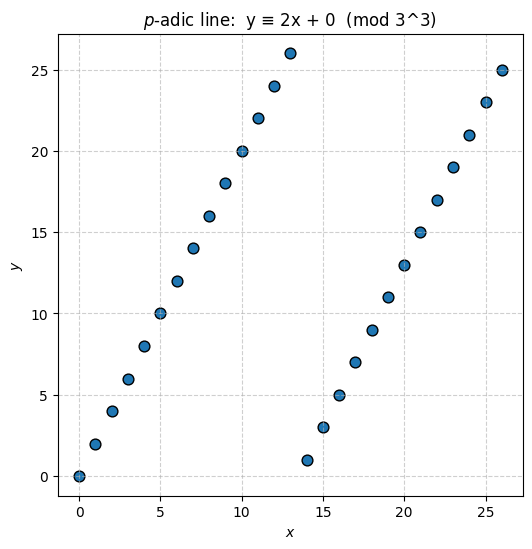

Plotting for a=2, b=3, p=3, n=3


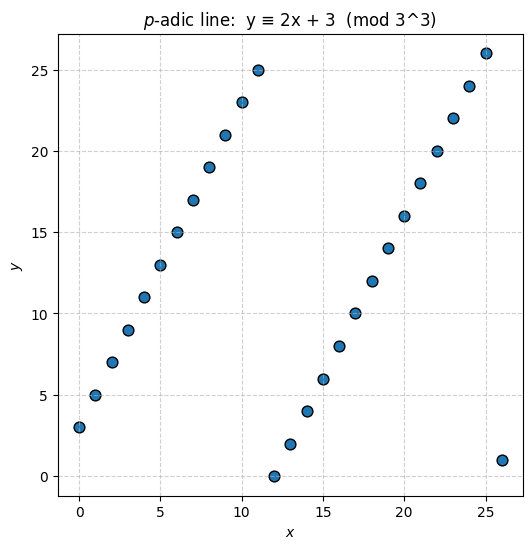

Plotting for a=1, b=5, p=3, n=4


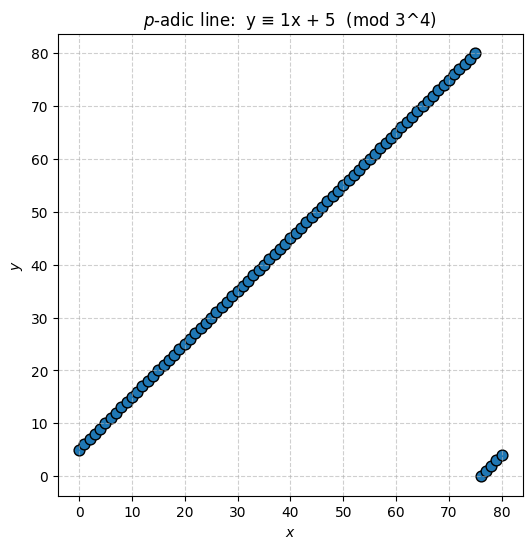

Plotting for a=2, b=0, p=3, n=4


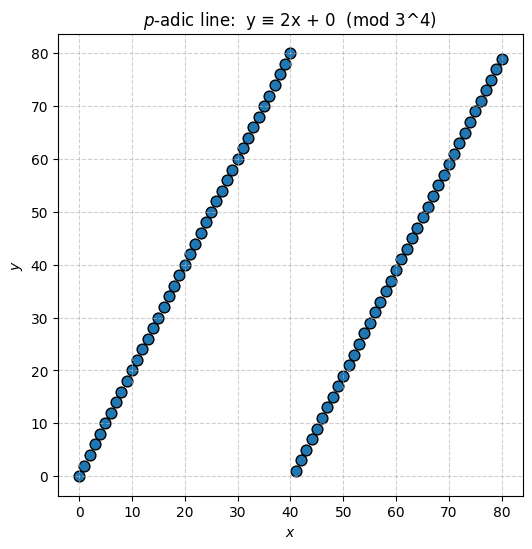

Plotting for a=1, b=0, p=3, n=5


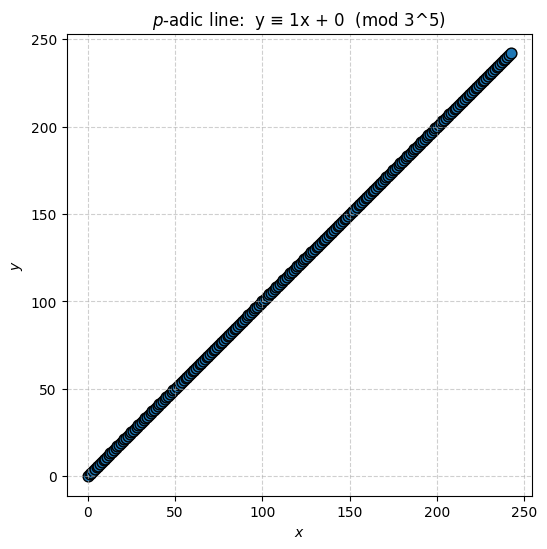

Plotting for a=2, b=10, p=3, n=5


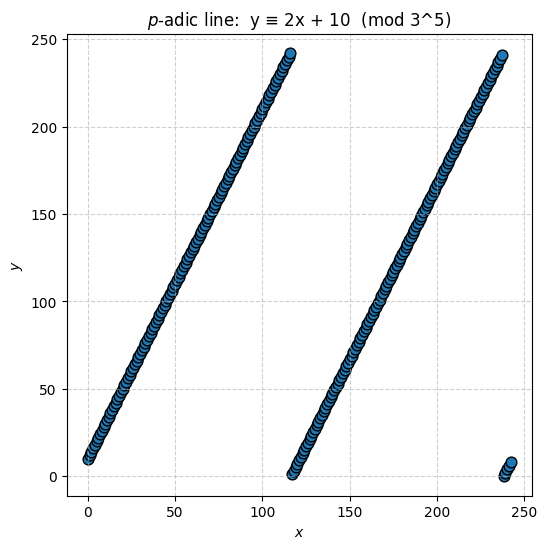

Plotting for a=1, b=0, p=5, n=2


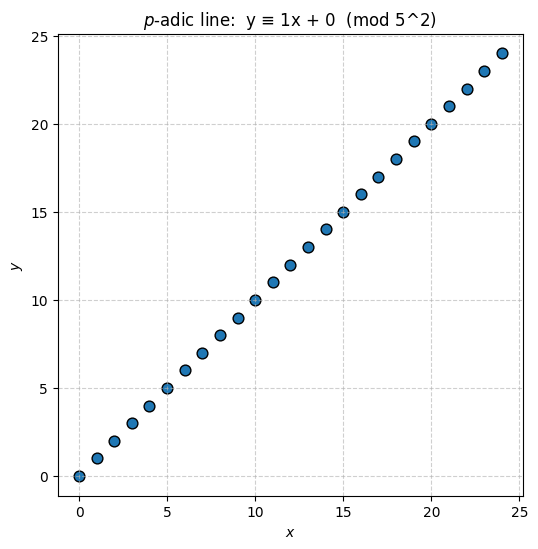

Plotting for a=2, b=3, p=5, n=2


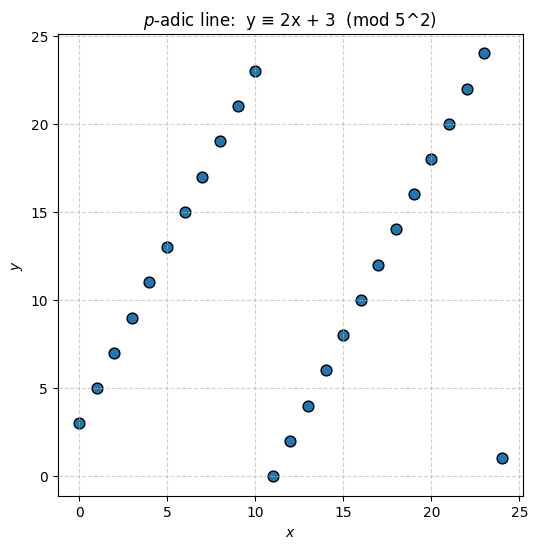

Plotting for a=3, b=4, p=5, n=2


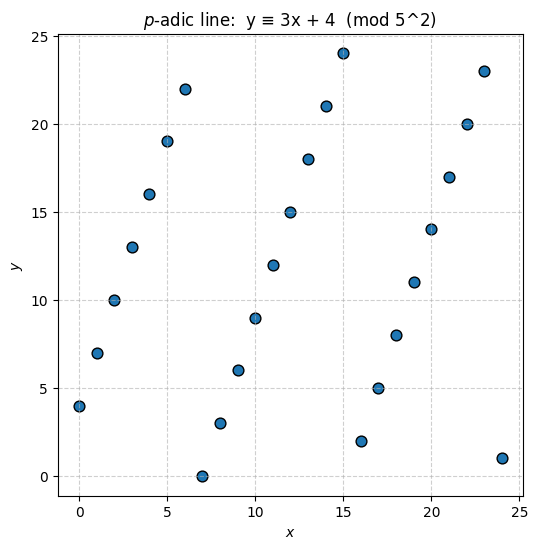

Plotting for a=4, b=0, p=5, n=3


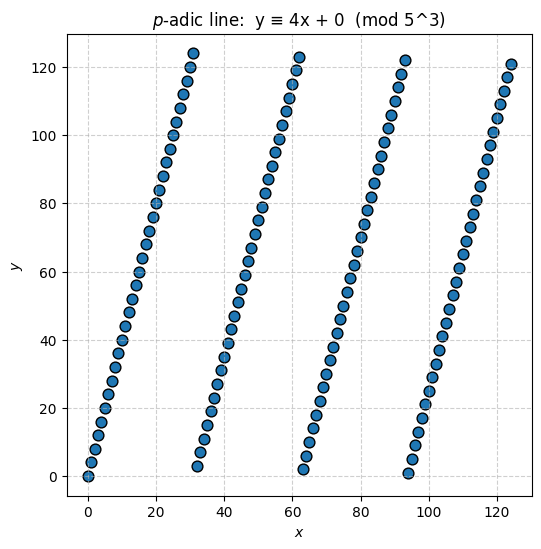

Plotting for a=4, b=3, p=5, n=3


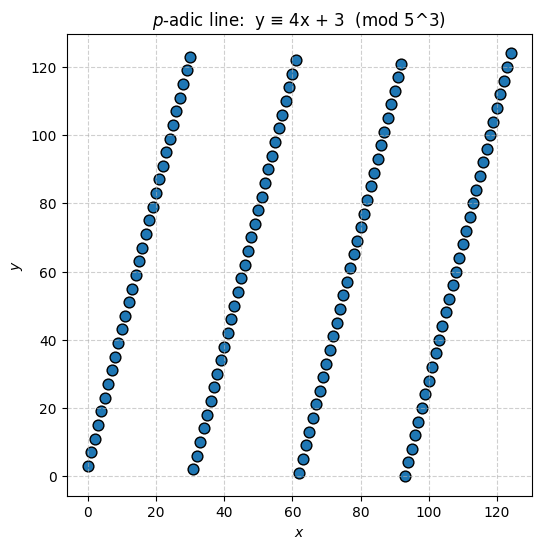

Plotting for a=2, b=7, p=5, n=3


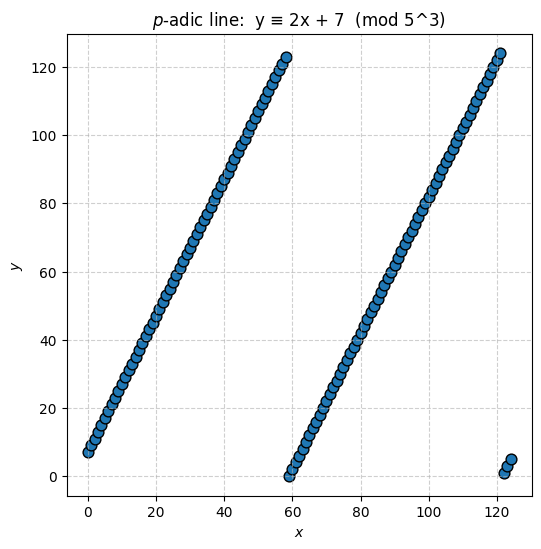

Plotting for a=1, b=0, p=5, n=4


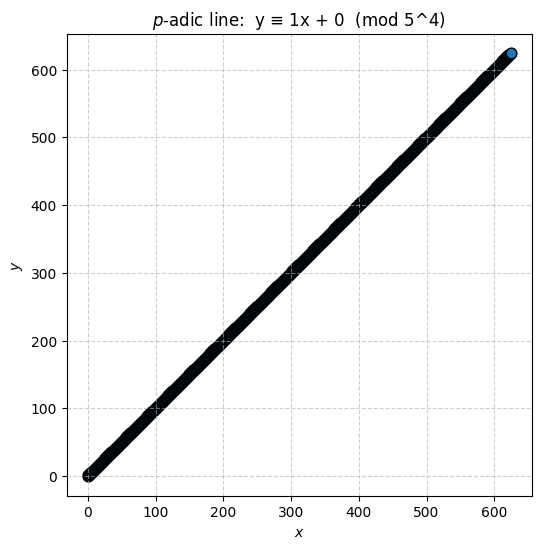

Plotting for a=2, b=15, p=5, n=4


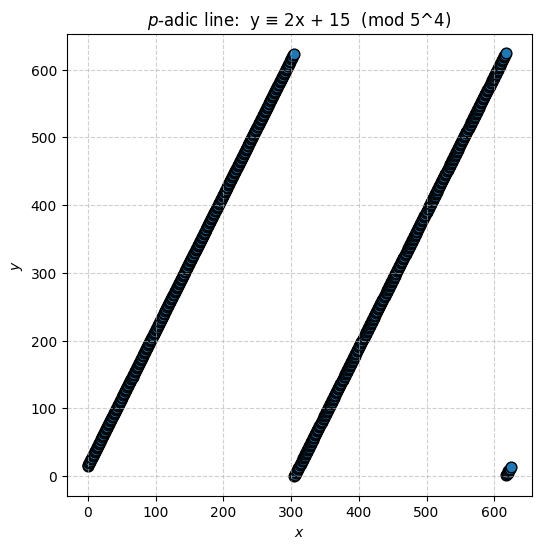

Plotting for a=3, b=60, p=5, n=4


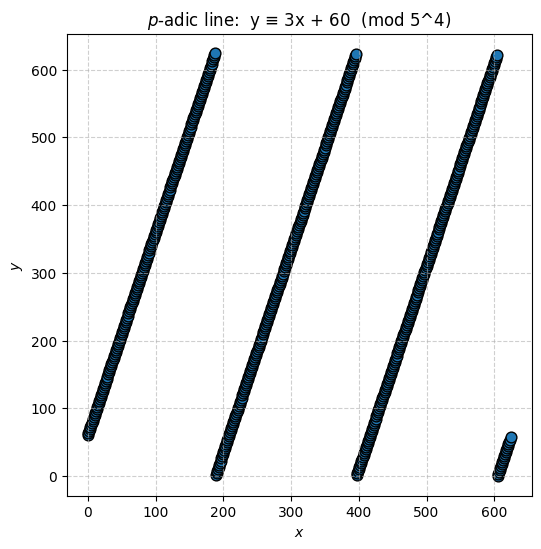

Plotting for a=1, b=0, p=7, n=2


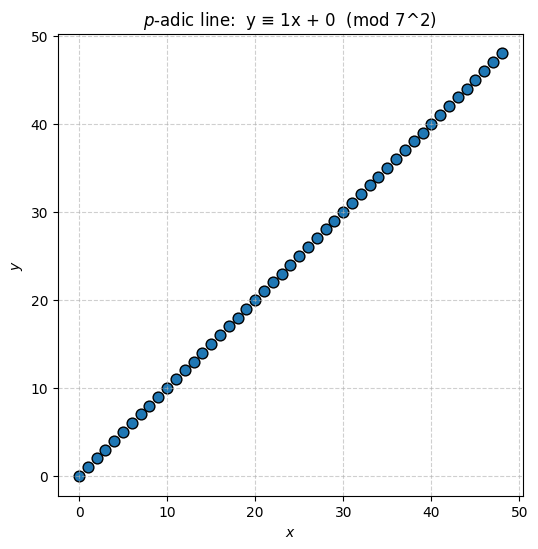

Plotting for a=2, b=3, p=7, n=2


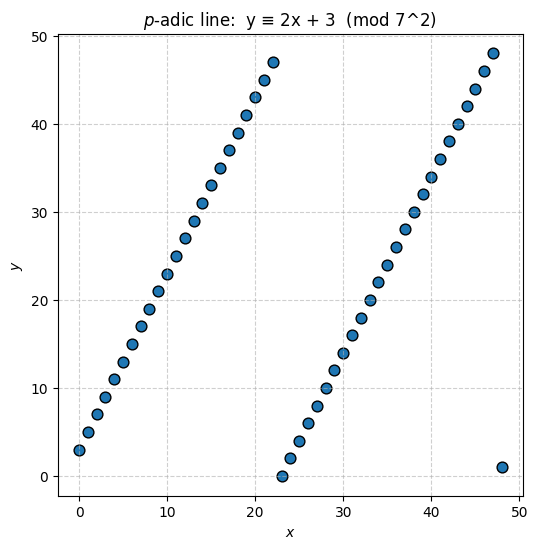

Plotting for a=3, b=5, p=7, n=2


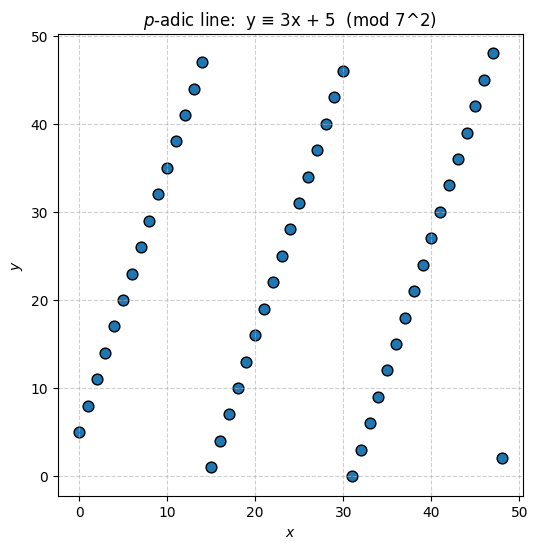

Plotting for a=5, b=10, p=7, n=3


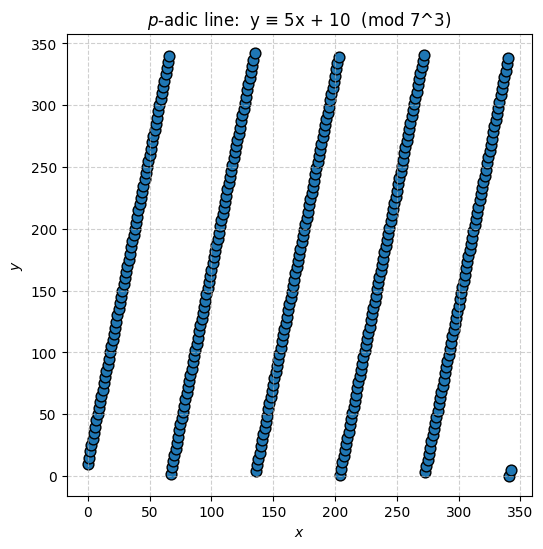

Plotting for a=6, b=0, p=7, n=3


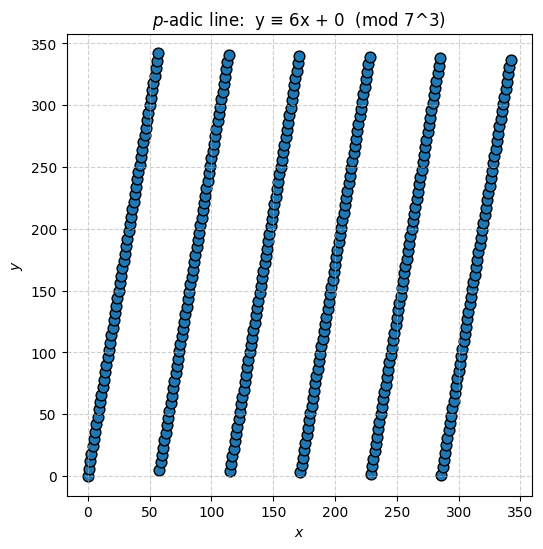

Plotting for a=3, b=40, p=7, n=3


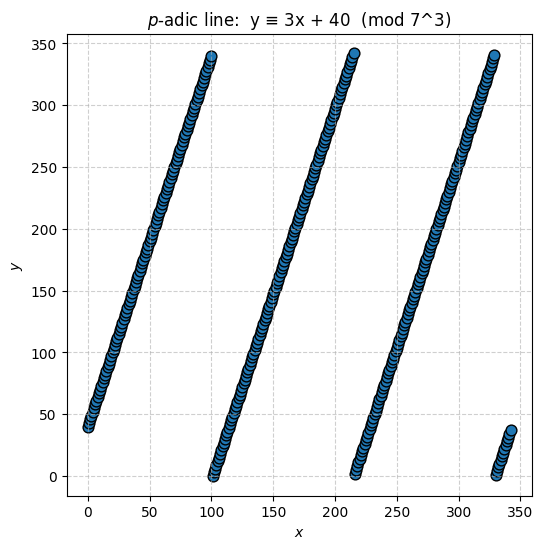

Plotting for a=1, b=0, p=7, n=4


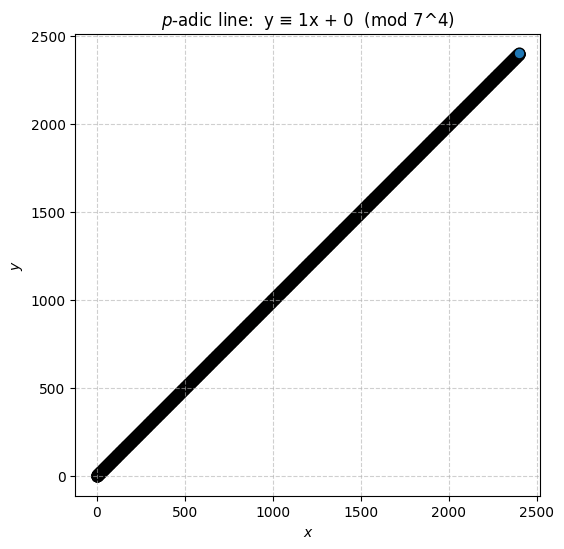

Plotting for a=2, b=300, p=7, n=4


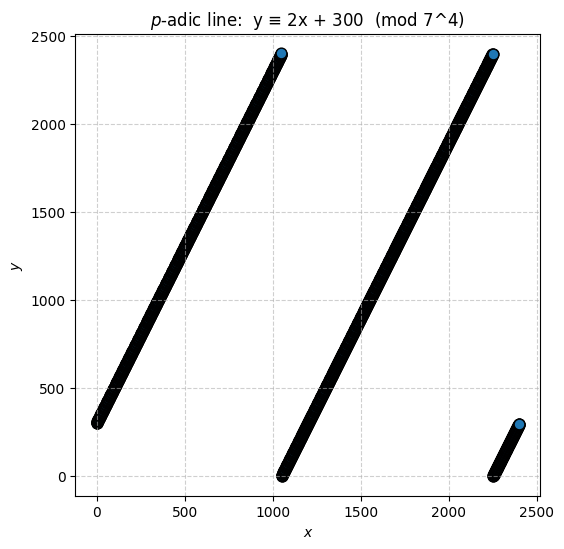

Plotting for a=2, b=1, p=2, n=3


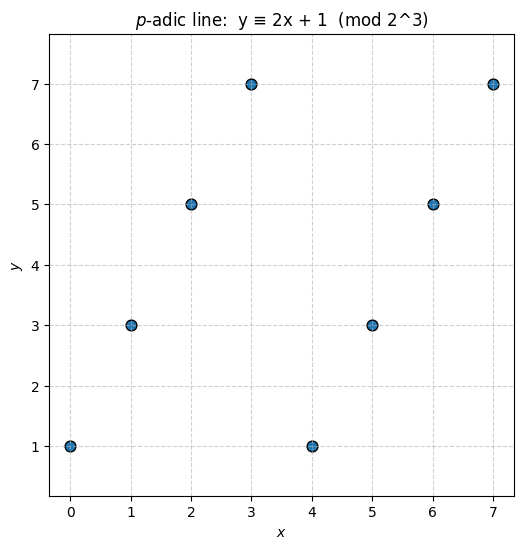

Plotting for a=3, b=1, p=3, n=3


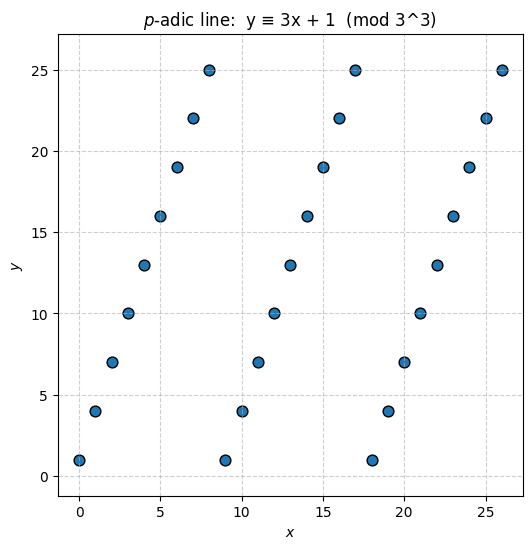

Plotting for a=5, b=1, p=5, n=3


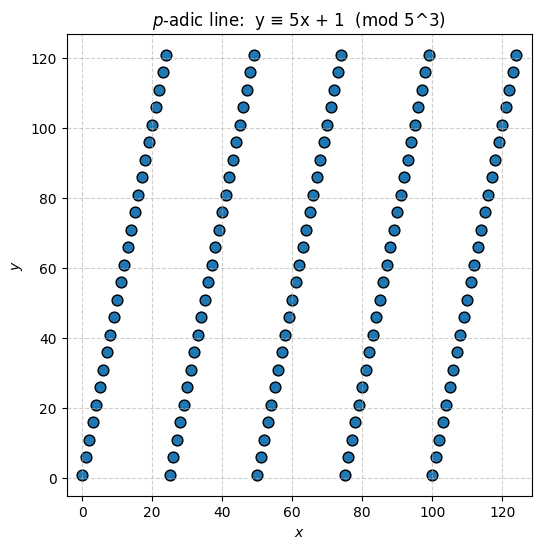

Plotting for a=7, b=1, p=7, n=3


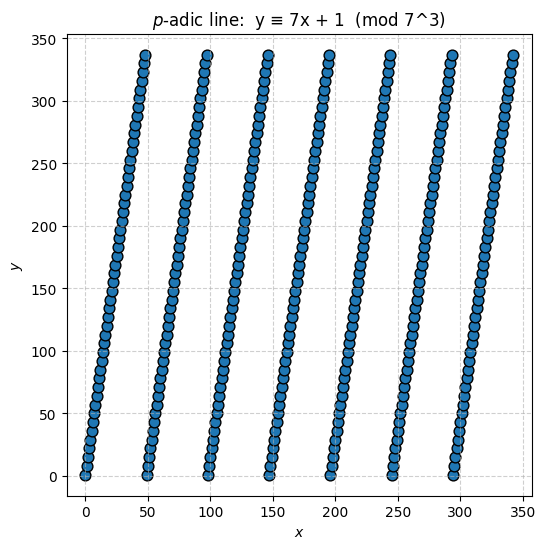

In [275]:
examples = [
    # ===== Base p = 2 ===== 
    (1, 0, 2, 3),    # identity line y = x (mod 8)
    (1, 1, 2, 3),    # y = x + 1
    (3, 0, 2, 4),    # slope 3, mod 16
    (5, 7, 2, 5),    # steeper slope with offset, mod 32
    (1, 0, 2, 6),    # identity line at higher depth

    # ===== Base p = 3 =====
    (1, 0, 3, 3),    # y = x mod 27
    (2, 0, 3, 3),    # y = 2x
    (2, 3, 3, 3),    # y = 2x + 3
    (1, 5, 3, 4),    # y = x + 5, mod 81
    (2, 0, 3, 4),    # y = 2x, mod 81
    (1, 0, 3, 5),    # y = x, mod 243
    (2, 10, 3, 5),   # slope 2, intercept 10, mod 243

    # ===== Base p = 5 =====
    (1, 0, 5, 2),    # y = x mod 25
    (2, 3, 5, 2),    # y = 2x + 3 mod 25
    (3, 4, 5, 2),    # y = 3x + 4 mod 25
    (4, 0, 5, 3),    # y = 4x mod 125
    (4, 3, 5, 3),    # y = 4x + 3 mod 125
    (2, 7, 5, 3),    # y = 2x + 7 mod 125
    (1, 0, 5, 4),    # y = x mod 625 (dense)
    (2, 15, 5, 4),   # y = 2x + 15 mod 625
    (3, 60, 5, 4),   # y = 3x + 60 mod 625

    # ===== Base p = 7 =====
    (1, 0, 7, 2),    # y = x mod 49
    (2, 3, 7, 2),    # y = 2x + 3 mod 49
    (3, 5, 7, 2),    # y = 3x + 5 mod 49
    (5, 10, 7, 3),   # y = 5x + 10 mod 343
    (6, 0, 7, 3),    # y = 6x mod 343 (negative slope analogue)
    (3, 40, 7, 3),   # y = 3x + 40 mod 343
    (1, 0, 7, 4),    # y = x mod 2401
    (2, 300, 7, 4),  # y = 2x + 300 mod 2401

]  

# ======================================================
# Flatten examples list (remove any nested lists)
# ======================================================
flat_examples = []
for e in examples:
    if isinstance(e, tuple):
        flat_examples.append(e)
    else:
        flat_examples.extend(e)
examples = flat_examples

# ======================================================
# Append the universal family y = p*x + 1 (mod p^3)
# ======================================================
examples.extend([(p, 1, p, 3) for p in [2, 3, 5, 7]])

# ======================================================
# Display / Plot all examples
# ======================================================
for (a, b, p, n) in examples:
    print(f"Plotting for a={a}, b={b}, p={p}, n={n}")
    try:
        p_adic_line(a, b, p, n)
    except Exception as err:
        print(f"⚠️ Error for (a={a}, b={b}, p={p}, n={n}): {err}")


In [341]:
import math
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt
# =====================================================
# Function 1: p-adic sine series (exact rationals)
# =====================================================
def sin_calculation(x, p, terms):
    sequence = []
    for i in range(0,terms+1):
        numerator = int((-1)**i * (x ** (2*i + 1)))
        denominator = int(math.factorial(2*i + 1))
        sequence.append(Fraction(numerator, denominator))
    return sum(sequence)

# =====================================================
# Function 2: p-adic logarithm series (exact rationals)
# =====================================================
def log_calculation(x, p, terms):
    sequence = []
    for i in range(1, terms + 1):
        numerator = int((-1)**(i+1) * (x ** i))
        denominator = int(i)
        sequence.append(Fraction(numerator, denominator))
    return sum(sequence)

# =====================================================
# 3. Exponential series calculation (exact rationals)
# =====================================================
def exp_calculation(x, p, terms):
    sequence = []
    for i in range(0,terms+1):
        numerator =int((x ** i))
        denominator = int(math.factorial(i))
        sequence.append(Fraction(numerator, denominator))
    return sum(sequence)

In [343]:
# =====================================================
# Helper: p-adic valuation
# =====================================================
def v_p(x, p):
    """Return p-adic valuation v_p(x) = highest power of p dividing x."""
    if x == 0:
        return math.inf
    v = 0
    while x % p == 0:
        x //= p
        v += 1
    return v

# =====================================================
# Generic series evaluator with convergence checks
# =====================================================
def p_adic_series(func, p, n, terms, x_min=0, x_max=30):
    x_input = np.arange(x_min, x_max + 1, dtype=object)
    y_output = np.zeros(x_input.shape, dtype=object)
    exp_sin_threshold = 1 / (p - 1)   # v_p(x) > 1/(p-1)
    log_threshold = 0                 # v_p(x) > 0 ⇔ |x|_p < 1

    for i, x in enumerate(x_input):
        vp_x = v_p(x, p)
        if func == sin_calculation:
            convergent = (vp_x > exp_sin_threshold)
        elif func == log_calculation:
            convergent = (vp_x > log_threshold)
        elif func == exp_calculation:
            convergent = (vp_x > exp_sin_threshold)
        else:
            convergent = True

        if convergent:
            frac = func(x, p, terms)
            a, b = frac.numerator, frac.denominator
            if math.gcd(b, p) != 1:
                y_output[i] = None  # noninvertible denominator
            else:
                y_output[i] = p_adic_remainder(a,b,p,n)
        else:
            y_output[i] = None

    return x_input, y_output, exp_sin_threshold, log_threshold



In [450]:
# =====================================================
# Plot for p-adic sine
# =====================================================
def graphing_sin(p, n, terms, x_min=0, x_max=50):
    x_input, y_output, exp_sin_threshold, _ = p_adic_series(sin_calculation, p, n, terms, x_min, x_max)
    valid_x = [x for x, y in zip(x_input, y_output) if y is not None]
    valid_y = [y for y in y_output if y is not None]

    plt.figure(figsize=(7,7))
    plt.scatter(valid_x, valid_y, s=12, color='crimson', label='Convergent points')
    plt.title(f"$p$-adic $\\sin(x)$ mod $p^{{{n}}}$  (p={p}, n={n})")
    plt.xlabel("$x$")
    plt.ylabel("$\\sin_p(x)$ series mod $p^n$")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    print(f"Convergence condition for sin_p(x): v_p(x) > {exp_sin_threshold:.3f}")
    print(f"  → |x|_p < p^(-1/(p-1)) = {p**(-1/(p-1)):.4f}")
    plt.tight_layout()
    plt.show()

# =====================================================
# Plot for p-adic logarithm
# =====================================================
def graphing_log(p, n, terms, x_min=0, x_max=50):
    x_input, y_output, _, log_threshold = p_adic_series(log_calculation, p, n, terms, x_min, x_max)
    valid_x = [x for x, y in zip(x_input, y_output) if y is not None]
    valid_y = [y for y in y_output if y is not None]

    plt.figure(figsize=(7,7))
    plt.scatter(valid_x, valid_y, s=12, color='seagreen', label='Convergent points')
    plt.title(f"$p$-adic $\\log(1+x)$ mod $p^{{{n}}}$  (p={p}, n={n})")
    plt.xlabel("$x$")
    plt.ylabel("$\\log_p(1+x)$ series mod $p^n$")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    print(f"Convergence condition for log_p(1+x): v_p(x) > {log_threshold}")
    print(f"  → |x|_p < 1")
    plt.tight_layout()
    plt.show()
# =====================================================
# Plot for p-adic sine
# =====================================================
def graphing_exp(p, n, terms, x_min=0, x_max=100):
    x_input, y_output, exp_sin_threshold, _ = p_adic_series(exp_calculation, p, n, terms, x_min, x_max)
    valid_x = [x for x, y in zip(x_input, y_output) if y is not None]
    valid_y = [y for y in y_output if y is not None]

    plt.figure(figsize=(7,7))
    plt.scatter(valid_x, valid_y, s=12, color='crimson', label='Convergent points')
    plt.title(f"$p$-adic $\\exp(x)$ mod $p^{{{n}}}$  (p={p}, n={n})")
    plt.xlabel("$x$")
    plt.ylabel("$\\exp(x)$ series mod $p^n$")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    print(f"Convergence condition for sin_p(x): v_p(x) > {exp_sin_threshold:.3f}")
    print(f"  → |x|_p < p^(-1/(p-1)) = {p**(-1/(p-1)):.4f}")
    plt.tight_layout()
    plt.show()

Convergence condition for sin_p(x): v_p(x) > 0.500
  → |x|_p < p^(-1/(p-1)) = 0.5774


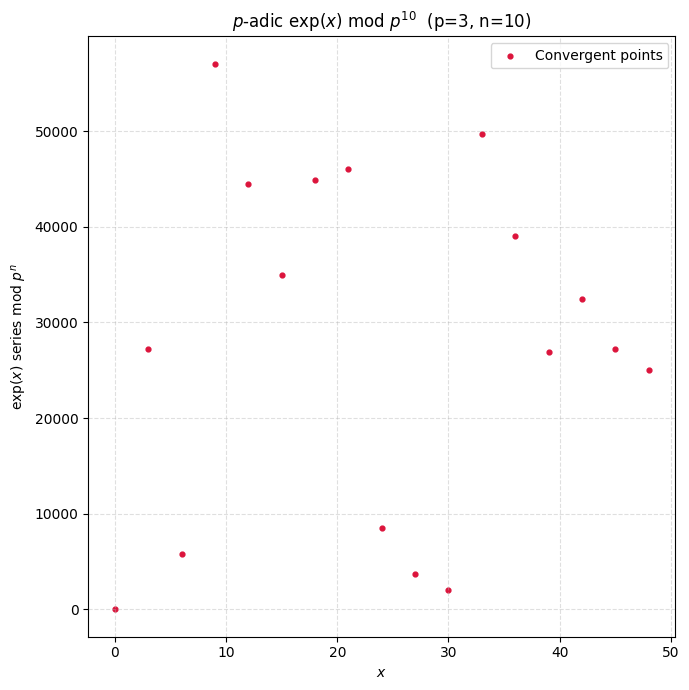

Convergence condition for sin_p(x): v_p(x) > 0.500
  → |x|_p < p^(-1/(p-1)) = 0.5774


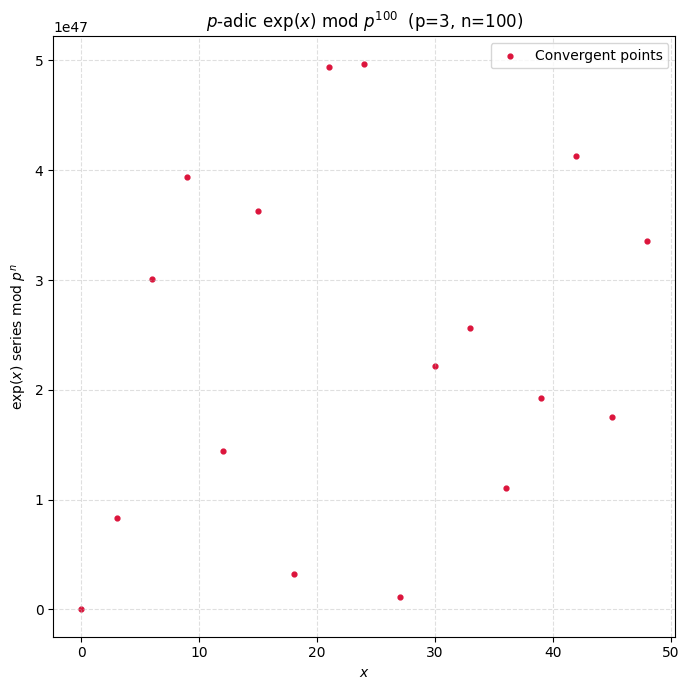

Convergence condition for sin_p(x): v_p(x) > 0.500
  → |x|_p < p^(-1/(p-1)) = 0.5774


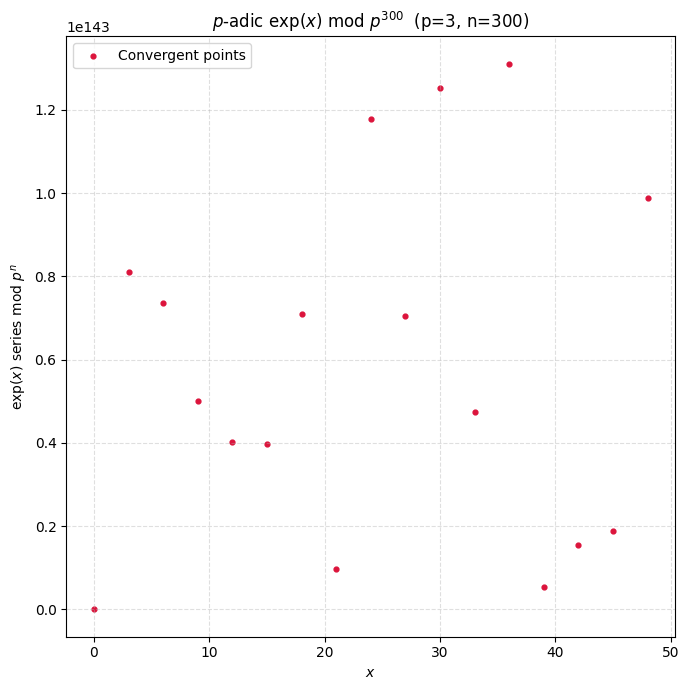

In [464]:
graphing_exp(3, 10, 100)
graphing_exp(3, 100, 100)
graphing_exp(3, 300, 100)